<a id='Top'></a>

# Prepare imaging data <a class='tocSkip'></a>

Use an offline patching scheme to sample patches from whole-slide images (WSIs) ahead of model training/testing. Generate a file per patient (as for other data modalities), but containing the file names of image patches sampled from that patient's WSI `.svs` files, rather than the data. These are used by the PyTorch dataset to load patient image patches.

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext watermark

import os
from io import StringIO
import json
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import requests

In [2]:
DATA_LOCATION = '/mnt/dataA/TCGA/processed/WSI/'

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Subset-manifest-file" data-toc-modified-id="Subset-manifest-file-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Subset manifest file</a></span></li><li><span><a href="#Map-files-to-patients" data-toc-modified-id="Map-files-to-patients-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Map files to patients</a></span><ul class="toc-item"><li><span><a href="#Drop-unused-patients" data-toc-modified-id="Drop-unused-patients-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Drop unused patients</a></span></li></ul></li><li><span><a href="#Slides-with-max-20x-magnification" data-toc-modified-id="Slides-with-max-20x-magnification-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Slides with max 20x magnification</a></span><ul class="toc-item"><li><span><a href="#Collect-slide-magnifications" data-toc-modified-id="Collect-slide-magnifications-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Collect slide magnifications</a></span></li><li><span><a href="#Save-slide-magnifications-to-file" data-toc-modified-id="Save-slide-magnifications-to-file-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Save slide magnifications to file</a></span></li><li><span><a href="#Check-unread-slides" data-toc-modified-id="Check-unread-slides-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Check unread slides</a></span></li><li><span><a href="#Drop-unusable-slides" data-toc-modified-id="Drop-unusable-slides-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Drop unusable slides</a></span><ul class="toc-item"><li><span><a href="#Drop-slides-slides-missing-magnification-or-with-20x-magnification" data-toc-modified-id="Drop-slides-slides-missing-magnification-or-with-20x-magnification-3.4.1"><span class="toc-item-num">3.4.1&nbsp;&nbsp;</span>Drop slides slides missing magnification or with 20x magnification</a></span></li><li><span><a href="#Drop-patients-with-no-remaining-slides" data-toc-modified-id="Drop-patients-with-no-remaining-slides-3.4.2"><span class="toc-item-num">3.4.2&nbsp;&nbsp;</span>Drop patients with no remaining slides</a></span></li></ul></li></ul></li><li><span><a href="#Generate-patient-files" data-toc-modified-id="Generate-patient-files-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Generate patient files</a></span></li><li><span><a href="#Offline-patching" data-toc-modified-id="Offline-patching-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Offline patching</a></span><ul class="toc-item"><li><span><a href="#Count-generated-patches-per-slide" data-toc-modified-id="Count-generated-patches-per-slide-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Count generated patches per slide</a></span></li><li><span><a href="#Generate-patient-files" data-toc-modified-id="Generate-patient-files-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Generate patient files</a></span></li><li><span><a href="#Reorganize-directory" data-toc-modified-id="Reorganize-directory-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Reorganize directory</a></span></li><li><span><a href="#Delete-bad-patches" data-toc-modified-id="Delete-bad-patches-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Delete bad patches</a></span><ul class="toc-item"><li><span><a href="#Find-outliers" data-toc-modified-id="Find-outliers-5.4.1"><span class="toc-item-num">5.4.1&nbsp;&nbsp;</span>Find outliers</a></span></li><li><span><a href="#Visualize-outlier-examples" data-toc-modified-id="Visualize-outlier-examples-5.4.2"><span class="toc-item-num">5.4.2&nbsp;&nbsp;</span>Visualize outlier examples</a></span></li><li><span><a href="#Delete-outlier-patch-files" data-toc-modified-id="Delete-outlier-patch-files-5.4.3"><span class="toc-item-num">5.4.3&nbsp;&nbsp;</span>Delete outlier patch files</a></span></li><li><span><a href="#Generate-patient-files" data-toc-modified-id="Generate-patient-files-5.4.4"><span class="toc-item-num">5.4.4&nbsp;&nbsp;</span>Generate patient files</a></span></li></ul></li></ul></li><li><span><a href="#Compute-patch-mean-and-std" data-toc-modified-id="Compute-patch-mean-and-std-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Compute patch mean and std</a></span></li></ul></div>

# Subset manifest file

Used only to resume an interrupted download:

> Create a new manifest file with the subset of the original rows containing all non-downloaded files. Then repeat `gdc-client download` command.

# Map files to patients

Use the [GDC API](https://docs.gdc.cancer.gov/API/Users_Guide/Python_Examples/#using-python-to-query-the-gdc-api) to retrieve mapping between file names and patient IDs. Collect results as Pandas `DataFrame`.

In [3]:
def request_file_info(data_type):
    fields = [
        "file_name",
        "cases.submitter_id",
        "cases.samples.sample_type",
        "cases.project.project_id",
        "cases.project.primary_site",
        ]

    fields = ",".join(fields)

    files_endpt = "https://api.gdc.cancer.gov/files"

    filters = {
        "op": "and",
        "content":[
            {
            "op": "in",
            "content":{
                "field": "files.experimental_strategy",
                "value": [data_type]
                }
            }
        ]
    }

    params = {
        "filters": filters,
        "fields": fields,
        "format": "TSV",
        "size": "200000"
        }

    response = requests.post(files_endpt, headers = {"Content-Type": "application/json"}, json = params)

    return pd.read_csv(StringIO(response.content.decode("utf-8")), sep="\t")

In [4]:
wsi_files = request_file_info(data_type='Diagnostic Slide')
wsi_files.shape

(11766, 7)

In [5]:
wsi_files.head()

,cases.0.project.primary_site,cases.0.project.project_id,cases.0.samples.0.sample_type,cases.0.samples.1.sample_type,cases.0.submitter_id,file_name,id
0,Kidney,TCGA-KIRC,Primary Tumor,NaN,TCGA-CZ-5457,TCGA-CZ-5457-01Z-00-DX1.87f21980-bf6b-4da6-ae8...,0fbff110-413c-443d-aa0a-ee40f2cf2aab
1,Head and Neck,TCGA-HNSC,Primary Tumor,NaN,TCGA-BB-7866,TCGA-BB-7866-01Z-00-DX1.144872E0-8C08-42CC-ACD...,1d5ad259-f5b4-4905-a68e-2c770a19287e
2,Kidney,TCGA-KIRC,Primary Tumor,NaN,TCGA-BP-4346,TCGA-BP-4346-01Z-00-DX1.e2f7b4ce-fbe8-482e-822...,1f96abc7-4dd7-4672-ba37-463c2d0b6eac
3,Colorectal,TCGA-COAD,Primary Tumor,NaN,TCGA-AA-A00R,TCGA-AA-A00R-01Z-00-DX1.7520405C-E7DD-46A4-BB6...,397337b9-9f03-4edc-935d-a0d4e15bf006
4,Colorectal,TCGA-COAD,Primary Tumor,NaN,TCGA-CM-5861,TCGA-CM-5861-01Z-00-DX1.b900abc0-ecca-48e1-98b...,c27f930d-beaf-45f2-9804-89a94f0372b1


In [6]:
wsi_files = wsi_files[wsi_files['cases.0.project.project_id'].str.startswith('TCGA')]
wsi_files = wsi_files[wsi_files['file_name'].str.endswith('.svs')]
wsi_files = wsi_files[wsi_files['cases.0.samples.0.sample_type'] == 'Primary Tumor']
wsi_files.shape

(11551, 7)

In [7]:
print('All rows:       ', wsi_files.shape[0])
print('Unique patients:', wsi_files['cases.0.submitter_id'].unique().shape[0])

All rows:        11551
Unique patients: 9498


In [8]:
def make_patient_file_map(df, base_dir):
    d = {}
    
    for _, row in df.iterrows():
        patient = row['cases.0.submitter_id']
        if patient in d:
            if not isinstance(d[patient], tuple):
                d[patient] = (
                    d[patient],
                    os.path.join(base_dir, row.id, row.file_name))
            else:
                d[patient] += os.path.join(base_dir, row.id, row.file_name),
        else:
            d[patient] = os.path.join(base_dir, row.id, row.file_name)

    return d

In [9]:
file_map = make_patient_file_map(wsi_files, base_dir='')
len(file_map)

9498

In [10]:
file_map[list(file_map.keys())[0]]

'0fbff110-413c-443d-aa0a-ee40f2cf2aab/TCGA-CZ-5457-01Z-00-DX1.87f21980-bf6b-4da6-ae8e-f7fef7396d52.svs'

## Drop unused patients

Keep only patients present in label data.

In [11]:
labels = pd.read_csv('labels.tsv', sep='\t')
len(labels['submitter_id'])

11081

In [12]:
labels.head()

,submitter_id,project_id,time,event,group
0,TCGA-3B-A9HI,SARC,4.167123,0,val
1,TCGA-3B-A9HJ,SARC,3.024658,0,train
2,TCGA-3B-A9HL,SARC,1.641096,1,train
3,TCGA-3B-A9HO,SARC,2.627397,0,train
4,TCGA-3B-A9HP,SARC,4.457534,1,val


In [13]:
file_map = {k: file_map[k] for k in file_map if k in list(labels['submitter_id'])}

In [14]:
len(file_map)

9425

In [15]:
slide_counts = {}

for patient in file_map:
    slides = file_map[patient]
    if isinstance(slides, tuple):
        slide_counts[patient] = len(slides)

print(len(slide_counts), 'patients with more than one slide')
print(f'(with {round(np.mean(list(slide_counts.values())), 2)} slides per patient)')

831 patients with more than one slide
(with 3.44 slides per patient)


# Slides with max 20x magnification

There are slides with a maximum magnification of 20x instead of 40x. Drop these slides from the data.

> __Note:__ De to the large size of the data, I have sp;it and stored it across four different locations.

## Collect slide magnifications

## Save slide magnifications to file

## Check unread slides

Function `get_slide_mag()` returns the slide file name when the magnification is not found (no `'aperio.AppMag'` found in `Slide` attributes).

Start by checking unreadable slides and manually download the cases where the problem is partial original downloads.

## Drop unusable slides

Start by checking magnifications for all flagged slides, in case the repaired files contain magnification values. Then drop both slides missing magnification info or with 20x maximum magnification and any patients with no remaining slides.

In [16]:
slide_mags = json.load(open('../data/wsi_magnifications.json'))

In [17]:
# Any patients with slide paths for which magnification is available?
patients_with_failed_slides = []

for patient in slide_mags:
    mags = slide_mags[patient]
    if not isinstance(mags, list):
        mags = [mags]
    for x in mags:
        if x.startswith('20') or x.startswith('40'):
            next
        else:
            patients_with_failed_slides += [patient]

In [18]:
len(slide_mags) == len(file_map)

True

In [19]:
def any_slide_mag(slide_file):
    try:
        wsi = slide.Slide(filename=slide_file)
        d = dict(wsi.properties)
        if 'aperio.AppMag' in d.keys():
            print(slide_file, d['aperio.AppMag'])
    except:
        print('Could not open file:', slide_file)

for patient in patients_with_failed_slides:
    mags = slide_mags[patient]
    if not isinstance(mags, list):
        mags = [mags]
    for mag in mags:
        if mag.startswith('20') or mag.startswith('40'):
            next
        else:
            any_slide_mag(mag)

Could not open file: /home/luis/net/Isilon/data.isilon/ag-rohr/bq_lsilva/WSI/2e405d74-1bf4-4b86-9b69-7f85774e5cad/TCGA-05-5425-01Z-00-DX1.85865B2F-4888-43DD-A501-458BEFCF832B.svs
Could not open file: /home/luis/net/Isilon/data.isilon/ag-rohr/bq_lsilva/WSI/bff964c6-145e-448d-8093-b5ee975d7b83/TCGA-05-5420-01Z-00-DX1.8C253A99-44FD-48B6-AF31-D808CCB7DB1E.svs
Could not open file: /home/luis/net/Isilon/data.isilon/ag-rohr/bq_lsilva/WSI/d42ec882-899c-4feb-b412-182142f80d7d/TCGA-05-5423-01Z-00-DX1.CCCF5FDB-ACAD-4D9D-80DF-556F0D6284AF.svs
Could not open file: /mnt/dataB/WSI/f8ac5923-4633-4606-8aab-bbdc3238ce1e/TCGA-05-4384-01Z-00-DX1.CA68BF29-BBE3-4C8E-B48B-554431A9EE13.svs
Could not open file: /mnt/dataB/WSI/c0b9dad4-1ec8-4541-afe3-27bfd087e348/TCGA-05-5429-01Z-00-DX1.20729065-FADA-4E43-98D7-AFA5FB4A0447.svs
Could not open file: /mnt/dataB/WSI/d236577c-da29-4d5c-ba46-d0079795d5d5/TCGA-05-4425-01Z-00-DX1.82B093EE-49BC-4FD9-91AC-4CC89944309D.svs
Could not open file: /home/luis/net/Isilon/data.i

In [20]:
slides_with_mags = ['/home/luis/net/Isilon/data.isilon/ag-rohr/bq_lsilva/WSI/430dc536-5441-443d-a3e0-159ecaf8fde2/TCGA-G9-A9S4-01Z-00-DX1.847AD7EA-278E-4E78-9465-1CA8229017AA.svs',
                    '/home/luis/net/Isilon/data.isilon/ag-rohr/bq_lsilva/WSI/5f6c2a1c-1d87-44b2-bed6-487403d3e9c9/TCGA-ZU-A8S4-01Z-00-DX1.90E3AC43-66E2-41E6-8253-487B95B4D7C9.svs',
                    '/home/luis/net/Isilon/data.isilon/ag-rohr/bq_lsilva/WSI/37e9c31f-ea56-482e-a1eb-d1a09bdae491/TCGA-2J-AAB6-01Z-00-DX1.2FC4D66F-BFBB-48FA-AFCB-ABBC12F37E14.svs']


for patient, mags in slide_mags.items():
    if mags in slides_with_mags:
        print(patient)

TCGA-G9-A9S4
TCGA-ZU-A8S4
TCGA-2J-AAB6


In [21]:
slide_mags['TCGA-G9-A9S4'] = '40'
slide_mags['TCGA-ZU-A8S4'] = '40'
slide_mags['TCGA-2J-AAB6'] = '40'

### Drop slides slides missing magnification or with 20x magnification

In [22]:
# Convert all values to list
for patient in slide_mags:
    if not isinstance(slide_mags[patient], list):
        slide_mags[patient] = [slide_mags[patient]]

# Drop 20x values
for patient in slide_mags:
    slide_mags[patient] = [x for x in slide_mags[patient]
                           if not x.startswith('20')]
    
# Drop file values
for patient in slide_mags:
    slide_mags[patient] = [x for x in slide_mags[patient]
                           if x.startswith('40')]

### Drop patients with no remaining slides

In [23]:
len(slide_mags)

9425

In [24]:
patients_with_no_slides = []

for patient in slide_mags:
    if not slide_mags[patient]:
        patients_with_no_slides += [patient]

In [25]:
len(patients_with_no_slides)

1040

In [26]:
slide_mags = {patient: v for patient, v in slide_mags.items()
              if patient not in patients_with_no_slides}

In [27]:
len(slide_mags)

8385

In [28]:
len(file_map)

9425

In [29]:
file_map = {patient: v for patient, v in file_map.items()
            if patient in slide_mags}

In [30]:
len(file_map)

8385

# Generate patient files

# Offline patching

Run dedicated script (found in `src/scripts` directory) with a selected input directory at a time.

Slide directories:
* `/home/luis/net/Isilon/data.isilon/ag-rohr/bq_lsilva/WSI/`
* `/home/luis/net/gpu_rig/bq_lsilva/WSI/`
* `/mnt/dataB/WSI/`
* `/mnt/dataB/nas_copy/data/Projects/imaging_genomics/TCGA_BRCA/diagnostic_slide/`

Generate a good number of patches per WSI. For example, 50 patches per slide will yield the following total numbers of patches:
* 302'450 for Isilon
* 134'600 for GPU rig
* 94'600 for `dataB`
* 56'650 for BRCA

Example command:

```bash
$ conda activate ig
$ python ./wsi_patcher.py \
   -i /home/luis/net/gpu_rig/bq_lsilva/WSI/ \
   -l ../../data/labels.tsv \
   -o /mnt/dataA/TCGA/processed/WSI/tissue_patches/ \
   -n 50
```

## Count generated patches per slide

Sanity check to make sure there is a balanced number of patches per each slide.

In [31]:
base_dir = DATA_LOCATION 

In [32]:
from collections import Counter

patches_named_as_slides = ['-'.join(os.path.basename(patch).split('-')[:3])
                           for patch in os.listdir(base_dir)]
    
c = Counter(patches_named_as_slides)

In [33]:
len([x for x in c if c[x] > 0])

8381

In [34]:
def how_many_patches_per_patient(patch_dir):
    patches_named_as_patients = ['-'.join(patch.split('-')[:3])
                                 for patch in os.listdir(patch_dir)]
    
    c = Counter(patches_named_as_patients)

    print(f'# patches: {len(patches_named_as_patients)}')
    print(f'# Represented patients: {len(c)}')
    unique_counts = set(c.values())
    print(f'Unique #s patches per patient: {unique_counts}')

In [35]:
location_paths = {
    'isilon': '/home/luis/net/Isilon/data.isilon/ag-rohr/bq_lsilva/WSI/',
    'gpu_rig': '/home/luis/net/gpu_rig/bq_lsilva/WSI/',
    'dataB': '/mnt/dataB/WSI/',
    'ig': '/mnt/dataB/nas_copy/data/Projects/imaging_genomics/TCGA_BRCA/diagnostic_slide/',
}

In [ ]:
%%time

location_files = {loc: os.listdir(location_paths[loc]) for loc in location_paths}

In [52]:
n_files = {loc: len(location_files[loc]) for loc in location_files}
n_files

{'isilon': 6046, 'gpu_rig': 2692, 'dataB': 1892, 'ig': 1133}

In [53]:
print('Total # of WSI files:', sum(n_files.values()))

Total # of WSI files: 11763


In [37]:
base_dir = os.path.join(DATA_LOCATION, 'tissue_patches')

how_many_patches_per_patient(patch_dir=base_dir)

# patches: 1072921
# Represented patients: 9557
Unique #s patches per patient: {650, 1550, 400, 21, 150, 800, 550, 299, 300, 700, 450, 199, 200, 599, 600, 350, 99, 100, 749, 750, 499, 500, 250, 1150}


## Generate patient files

In [36]:
def lookup_full_path(wsi_file, slide_paths, locations):
    file_path = None

    for location, leaf_dirs in slide_paths.items():
        for leaf_dir in leaf_dirs:
            if leaf_dir in wsi_file:
                file_path = os.path.join(locations[location], wsi_file)

    return file_path

In [39]:
base_dir = os.path.join(DATA_LOCATION, 'tissue_patches')

In [40]:
list(file_map.values())[0]

'722cf465-1d93-4f8e-98c0-a6c8be64b05f/TCGA-D1-A3DA-01Z-00-DX1.1A3346E9-8E0D-4BA2-A270-3FB8BA688490.svs'

In [41]:
def get_patientid_from(file):
    return '-'.join(str.split(file, '-')[:3])

def list_patch_files(patient_id, patch_dir):    
    patches = []
    
    for patch_file in os.listdir(patch_dir):
        if get_patientid_from(patch_file) == patient:
            patches.append(patch_file)
    
    if not patches:
        return None
    
    return patches

Check a couple of example patients.

In [42]:
eg_patient = list(file_map.keys())[0]

patient_patches = list_patch_files(eg_patient, base_dir)
print(f'Found {len(patient_patches)} patches for patient {eg_patient}.')
patient_patches[:5]

Found 100 patches for patient TCGA-D1-A3DA.


['TCGA-CG-5720-01Z-00-DX1_86708.png',
 'TCGA-CG-5720-01Z-00-DX1_e5e9f.png',
 'TCGA-CG-5720-01Z-00-DX1_969a7.png',
 'TCGA-CG-5720-01Z-00-DX1_c8978.png',
 'TCGA-CG-5720-01Z-00-DX1_95266.png']

In [43]:
eg_patient = 'TCGA-CJ-4870'

patient_patches = list_patch_files(eg_patient, base_dir)
print(f'Found {len(patient_patches)} patches for patient {eg_patient}.')
patient_patches[:5]

Found 100 patches for patient TCGA-CJ-4870.


['TCGA-CG-5720-01Z-00-DX1_86708.png',
 'TCGA-CG-5720-01Z-00-DX1_e5e9f.png',
 'TCGA-CG-5720-01Z-00-DX1_969a7.png',
 'TCGA-CG-5720-01Z-00-DX1_c8978.png',
 'TCGA-CG-5720-01Z-00-DX1_95266.png']

In [55]:
%%time

print('Write patient files:')
n = len(file_map)

unrepresented_patients = []

for i, patient in enumerate(file_map):
    print('\r' + f'{str((i + 1))}/{n}', end='')
    
    patch_dir = os.path.join(DATA_LOCATION, 'tissue_patches')
    patches = list_patch_files(patient, patch_dir)
    if patches is None:
        unrepresented_patients.append(patient)
        continue
    
    file_paths = [os.path.join(patch_dir, p)
                  for p in patches]
    
    target_file = os.path.join(base_dir, str(patient) + '.tsv')
   
    with open(target_file, 'w') as f:
        f.write('\n'.join(file_paths))
print()

Write patient files:
8385/8385
CPU times: user 1h 18min 28s, sys: 44min, total: 2h 2min 28s
Wall time: 2h 2min 26s


In [ ]:
print('# patients with no patches:')
print(len(unrepresented_patients))

In [57]:
unrepresented_patients

['TCGA-5P-A9KC',
 'TCGA-EM-A3AI',
 'TCGA-R5-A7ZR',
 'TCGA-5P-A9KA',
 'TCGA-19-1385']

In [44]:
# Not in selected patients!
unrepresented_patients = ['TCGA-5P-A9KC',
                          'TCGA-EM-A3AI',
                          'TCGA-5P-A9KA',
                          'TCGA-R5-A7ZR',
                          'TCGA-19-1385']

[x in labels.submitter_id for x in unrepresented_patients]

[False, False, False, False, False]

## Reorganize directory

Create a folder for each represented patient, move respective WSI patches into it, and, finally, update patch paths in patient files containing the list of patches for each patient.

In [44]:
len(os.listdir(DATA_LOCATION))

8381

In [45]:
os.listdir(DATA_LOCATION)[:5]

['TCGA-92-8064.tsv',
 'TCGA-FT-A3EE.tsv',
 'TCGA-IZ-A6M8.tsv',
 'TCGA-02-0058.tsv',
 'TCGA-22-4613.tsv']

In [53]:
%%time

patch_dir = os.path.join(DATA_LOCATION, 'tissue_patches')

patient_files = [x for x in os.listdir(DATA_LOCATION)
                 if x != 'tissue_patches']  # Avoid patch directory

for i, patient_file in enumerate(patient_files):
    print(f'\r' + f'Create patient directories:' +
          f' {str((i + 1))}/{len(patient_files)}', end='')
    patient = patient_file.split('.')[0]
    
    # Create patient dir
    patient_dir = os.path.join(patch_dir, patient)
    os.mkdir(patient_dir)
    
    # Move patient patches into directory
    patient_patches = list_patch_files(patient, patch_dir)
    patient_patches = [x for x in patient_patches if '.png' in x]  # Not the dir
    
    for patch in patient_patches:
        os.rename(os.path.join(patch_dir, patch),
                  os.path.join(patient_dir, patch))
print()
print()

Create patient directories: 8380/8380CPU times: user 44min 49s, sys: 22min 40s, total: 1h 7min 30s
Wall time: 1h 7min 49s


In [ ]:
%%time

# Update patient files
# (add patient directory to paths to patches)
patient_files = [x for x in os.listdir(DATA_LOCATION)
                 if x != 'tissue_patches']  # Avoid patch directory

for i, patient_file in enumerate(patient_files):
    print(f'\r' + f'Update paths in patient files:' +
          f' {str((i + 1))}/{len(patient_files)}', end='')
    
    patient = patient_file.split('.')[0]
    
    # Collect paths from file
    patient_file = os.path.join(DATA_LOCATION, patient_file)
    file_paths = [line.rstrip('\n') for line in open(patient_file)]
    
    # Add new dir name to path
    updated_paths = []
    
    for path in file_paths:
        path, file = path.split('tissue_patches')
        updated_path = os.path.join(path, '/tissue_patches/', patient, file)
        updated_paths.append(updated_path)
    
    # Write to patient file    
    with open(patient_file, 'w') as f:
        f.write('\n'.join(updated_paths))
print()
print()

Many patches remain that were not moved into specific patient directories. These will not be used by the PyTorch dataset, as they are not listed in specific patient files, so I will just delete them.

In [119]:
patch_dir = os.path.join(DATA_LOCATION, 'tissue_patches')

print('Number .png patch files:',
      len([x for x in os.listdir(patch_dir) if '.png' in x]))
print('Number of patch directories:',
      len([x for x in os.listdir(patch_dir) if not '.png' in x]))

Number .png patch files: 144394
Number of patch directories: 8380


In [120]:
for f in os.listdir(patch_dir):
    if '.png' in f:
        os.remove(os.path.join(patch_dir, f))

In [122]:
patch_dir = os.path.join(DATA_LOCATION, 'tissue_patches')

print('Number .png patch files:',
      len([x for x in os.listdir(patch_dir) if '.png' in x]))
print('Number of patch directories:',
      len([x for x in os.listdir(patch_dir) if not '.png' in x]))

Number .png patch files: 0
Number of patch directories: 8380


## Delete bad patches

Quick visual inspection shows that many patches are not suitable (contain mostly background, ink markings, ...).

Use a simple mean intensity filter to remove bad patches.

In [40]:
represented_patients = os.listdir(os.path.join(DATA_LOCATION, 'tissue_patches'))

In [154]:
len(represented_patients)

8380

In [155]:
patient_files = os.listdir(DATA_LOCATION)
patient_files = [f for f in patient_files if f != 'tissue_patches']
print(len(patient_files))

8380


In [71]:
def list_patient_patches(patient_id):
    path = os.path.join(DATA_LOCATION, 'tissue_patches', patient_id)
    files = os.listdir(path)
    paths = [os.path.join(DATA_LOCATION, 'tissue_patches', patient_id, f)
             for f in files]
    
    return paths

def load_patch(path):
    return mpimg.imread(path)

# from PIL import Image
# def load_patch(path):
#     return np.array(Image.open(path))

def compute_intensity_mean(patch, print_result=False):
    means = []

    for ch in range(3):
        means.append(patch[:, :, ch].mean())
        
    if print_result:
        print('Channel     Mean')
        for i, ch in enumerate('RGB'):
            print(f'  {ch}       {means[i]:2f}')

    return means

In [72]:
list_patient_patches(patient_id=represented_patients[0])[:5]

['/mnt/dataA/TCGA/processed/WSI/tissue_patches/TCGA-RW-A68A/TCGA-RW-A68A-01Z-00-DX1_a01eb.png',
 '/mnt/dataA/TCGA/processed/WSI/tissue_patches/TCGA-RW-A68A/TCGA-RW-A68A-01Z-00-DX1_a2300.png',
 '/mnt/dataA/TCGA/processed/WSI/tissue_patches/TCGA-RW-A68A/TCGA-RW-A68A-01Z-00-DX1_d94f0.png',
 '/mnt/dataA/TCGA/processed/WSI/tissue_patches/TCGA-RW-A68A/TCGA-RW-A68A-01Z-00-DX1_47d9f.png',
 '/mnt/dataA/TCGA/processed/WSI/tissue_patches/TCGA-RW-A68A/TCGA-RW-A68A-01Z-00-DX1_66efb.png']

In [73]:
patch = load_patch(list_patient_patches(patient_id=represented_patients[1])[0])
means = compute_intensity_mean(patch / 255., print_result=True)

Channel     Mean
  R       0.001814
  G       0.000762
  B       0.001741


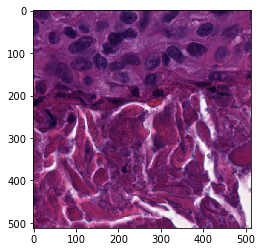

In [74]:
imgplot = plt.imshow(patch)

### Find outliers

In [75]:
def count_patches(patients):
    n = 0

    for patient in patients:
        n += len(list_patient_patches(patient))
    
    return n

In [87]:
patch_count = count_patches(patients=represented_patients)
print('Total number of patches:', patch_count)

Total number of patches: 928606


In [76]:
%%time

# Set thresholds by running some patients and looking at results
low = 0.35
high = 0.9

outlier_paths = []

for i, patient in enumerate(represented_patients):
    print(f'\r', f'Check all patients: {i}/{len(represented_patients)}',
          end='')
    patch_files = list_patient_patches(patient)

    for patch_file in patch_files:
        patch = load_patch(patch_file)
        means = compute_intensity_mean(patch, print_result=False)
        if not low < means[0] < high:
            outlier_paths.append(
                os.path.join(DATA_LOCATION, 'tissue_patches', patient, patch_file))

 Check all patients: 8379/8380CPU times: user 2h 50min 49s, sys: 3min 17s, total: 2h 54min 6s
Wall time: 5h 28min 17s


In [90]:
percent_patches = round(len(outlier_paths) * 100 / patch_count, 1)
patients = set([x.split('/')[-2] for x in outlier_paths])
percent_patients = round(len(patients) * 100 / len(represented_patients), 1)

print(f'{len(outlier_paths)} outlier patches out of {patch_count} ({percent_patches}%)')
print(f'from {len(patients)} patients out of {len(represented_patients)} ({percent_patients}%)')

33279 outlier patches out of 928606 (3.6%)
from 5141 patients out of 8380 (61.3%)


### Visualize outlier examples

Channel     Mean
  R       0.332040
  G       0.679982
  B       0.610262


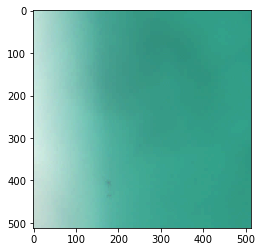

In [114]:
import random

i = random.randint(0, len(outlier_paths) - 1)
outlier_patch = load_patch(outlier_paths[i])
means = compute_intensity_mean(outlier_patch, print_result=True)
imgplot = plt.imshow(outlier_patch)

### Delete outlier patch files

In [123]:
all_patches = []
for pid in represented_patients:
    all_patches += list_patient_patches(patient_id=pid)

In [124]:
len(all_patches)

928606

In [132]:
def how_many_patches_per_patient(patches):
    patches_named_as_patients = ['-'.join(os.path.basename(patch).split('-')[:3])
                                 for patch in patches]
    
    c = Counter(patches_named_as_patients)

    print(f'# patches: {len(patches_named_as_patients)}')
    print(f'# Represented patients: {len(c)}')
    unique_counts = set(c.values())
    print(f'Unique #s patches per patient: {unique_counts}')

In [133]:
how_many_patches_per_patient(all_patches)

# patches: 928606
# Represented patients: 8380
Unique #s patches per patient: {650, 1550, 400, 150, 800, 550, 299, 300, 700, 450, 199, 200, 599, 600, 350, 99, 100, 749, 750, 499, 500, 250, 1150}


In [134]:
outlier_paths[:5]

['/mnt/dataA/TCGA/processed/WSI/tissue_patches/TCGA-RW-A68A/TCGA-RW-A68A-01Z-00-DX1_47d26.png',
 '/mnt/dataA/TCGA/processed/WSI/tissue_patches/TCGA-RW-A68A/TCGA-RW-A68A-01Z-00-DX1_79a8e.png',
 '/mnt/dataA/TCGA/processed/WSI/tissue_patches/TCGA-CV-7421/TCGA-CV-7421-01Z-00-DX1_05f81.png',
 '/mnt/dataA/TCGA/processed/WSI/tissue_patches/TCGA-CV-7421/TCGA-CV-7421-01Z-00-DX1_5e7bc.png',
 '/mnt/dataA/TCGA/processed/WSI/tissue_patches/TCGA-CV-7421/TCGA-CV-7421-01Z-00-DX1_4bdba.png']

In [ ]:
for f in outlier_paths:
    os.remove(f)

In [137]:
count_patches(patients=represented_patients)

895327

In [138]:
len(all_patches) - len(outlier_paths)

895327

### Generate patient files

Update patient files to account for deleted patches.

In [143]:
all_patches = []
for pid in represented_patients:
    all_patches += list_patient_patches(patient_id=pid)

In [156]:
all_patches_ids = list(set(['-'.join(os.path.basename(patch).split('-')[:3])
                            for patch in all_patches]))

for pid in represented_patients:
    if not pid in all_patches_ids:
        print(pid, 'no longer among represented patients')

TCGA-IB-7645 no longer among represented patients
TCGA-19-0957 no longer among represented patients
TCGA-S9-A6UA no longer among represented patients
TCGA-CH-5741 no longer among represented patients


In [157]:
len(all_patches)

895327

In [161]:
# Remove previous patient files
for f in os.listdir(DATA_LOCATION):
    if f != 'tissue_patches':
        os.remove(os.path.join(DATA_LOCATION, f))

In [162]:
os.listdir(DATA_LOCATION)

['tissue_patches']

In [163]:
patient_patch_map = {}

previous_id = None

for patch_path in all_patches:
    pid = '-'.join(os.path.basename(patch_path).split('-')[:3])
    
    if not pid in patient_patch_map.keys():
        patient_patch_map[pid] = [patch_path]
    else:
        patient_patch_map[pid].append(patch_path)

In [164]:
len(patient_patch_map)

8376

In [171]:
%%time

print('Write patient files:')

base_dir = '/mnt/dataA/TCGA/processed/WSI/'
n = len(patient_patch_map)

for i, (patient, files) in enumerate(patient_patch_map.items()):
    print('\r' + f'{str((i + 1))}/{n}', end='')
    
    target_file = os.path.join(DATA_LOCATION, str(patient) + '.txt')

    with open(target_file, 'w') as f:
        f.write('\n'.join(patient_files))
print()

Write patient files:
8376/8376
CPU times: user 656 ms, sys: 293 ms, total: 949 ms
Wall time: 747 ms


In [173]:
len([x for x in os.listdir(DATA_LOCATION) if x != 'tissue_patches'])

8376

# Compute patch mean and std

Since the mean and standard deviation values of the WSI patches may differ from the ImageNet values provided by PyTorch, compute here sensible overall values from the dataset.

The dataloader samples random examples from each patient's available patches, so run through full dataloader a couple of times to check variability.

In [5]:
import sys

# Make modules in "src" dir visible
if os.getcwd() not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), os.pardir, 'src'))

import utils

In [9]:
os.path.join(DATA_LOCATION, os.pardir)

'/mnt/dataA/TCGA/processed/WSI/..'

In [10]:
dataloaders = utils.get_dataloaders(data_location=os.path.join(DATA_LOCATION, os.pardir),
                                    labels_file='labels.tsv',
                                    modalities=['wsi'],
                                    wsi_patch_size=299,
                                    n_wsi_patches=1,
                                    batch_size=32,
#                                     exclude_patients=exclude_cancers
                                   )

Excluding 2192 patient(s) missing all data.
Excluding 279 patient(s) missing all data.
Excluding 234 patient(s) missing all data.
Data modalities:
   wsi

Dataset sizes (# patients):
   train: 6688
   val: 830
   test: 858

Batch size: 32


In [11]:
for x in dataloaders['train']:
    print(x[0]['wsi'].shape)
    break

torch.Size([32, 1, 3, 299, 299])


In [12]:
x[0]['wsi'][:, :, 0, :, :].mean()

tensor(0.6077)

In [13]:
x[0]['wsi'][:, :, 1, :, :].mean()

tensor(0.3855)

In [14]:
x[0]['wsi'][:, :, 2, :, :].mean()

tensor(0.5002)

In [15]:
x[0]['wsi'].shape[0]

32

In [16]:
import torch
from tqdm.notebook import tqdm

def compute_wsi_patch_stats(data_loader=dataloaders['train']):
    n_channels = 3
    n = len(data_loader.dataset)

    mean = torch.zeros(n_channels)
    std = torch.zeros(n_channels)

    print('Computing mean and std..')
    for minibatch in tqdm(data_loader):
        for j in range(minibatch[0]['wsi'].shape[0]):  # each individual patch
            for i in range(n_channels):
                mean_value = minibatch[0]['wsi'][:, :, i, :, :].mean()
                if mean_value > 0.1:  # avoid all-zero patches (missing data)
                    mean[i] += mean_value
                    std[i] += minibatch[0]['wsi'][:, :, i, :, :].std()
    mean.div_(n)
    std.div_(n)
    print(mean, std)
    
    return mean, std

In [17]:
multiple_run_means = []
multiple_run_stds = []

In [212]:
%%time

n_runs = 5

for _ in tqdm(range(n_runs)):
    mean, std = compute_wsi_patch_stats(data_loader=dataloaders['train'])
    
    multiple_run_means.append(mean)
    multiple_run_stds.append(std)
print()

Computing mean and std..



tensor([0.6439, 0.3901, 0.5068]) tensor([0.1971, 0.2203, 0.2035])
Computing mean and std..



tensor([0.6429, 0.3903, 0.5060]) tensor([0.1962, 0.2196, 0.2027])
Computing mean and std..



tensor([0.6412, 0.3884, 0.5048]) tensor([0.1959, 0.2179, 0.2013])
Computing mean and std..



tensor([0.6424, 0.3887, 0.5049]) tensor([0.1954, 0.2186, 0.2014])
Computing mean and std..



tensor([0.6425, 0.3882, 0.5049]) tensor([0.1965, 0.2196, 0.2028])


CPU times: user 52min 55s, sys: 42.9 s, total: 53min 38s
Wall time: 8min 59s


In [213]:
print('          -- Means --' + ' ' * 24 + '-- STDs --')
for i in range(len(multiple_run_means)):
    print(multiple_run_means[i], ' ', multiple_run_stds[i])

          -- Means --                        -- STDs --
tensor([0.6439, 0.3901, 0.5068])   tensor([0.1971, 0.2203, 0.2035])
tensor([0.6429, 0.3903, 0.5060])   tensor([0.1962, 0.2196, 0.2027])
tensor([0.6412, 0.3884, 0.5048])   tensor([0.1959, 0.2179, 0.2013])
tensor([0.6424, 0.3887, 0.5049])   tensor([0.1954, 0.2186, 0.2014])
tensor([0.6425, 0.3882, 0.5049])   tensor([0.1965, 0.2196, 0.2028])


# Watermark <a class='tocSkip'></a>

In [214]:
%watermark --iversions
%watermark -v
print()
%watermark -u -n

numpy     1.18.1
torch     1.4.0
pandas    1.0.1
PIL.Image 7.0.0
requests  2.22.0
json      2.0.9

CPython 3.6.7
IPython 7.11.1

last updated: Thu Apr 30 2020


[Top of the page](#Top)